In [1]:
import os
import gc
import math
import torch
import random
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# define dataset
class HemoglobinDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    # Knowing the length can help dataloader automatically generate batches
    def __len__(self):
        return len(self.X)  # return the number of sample

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X, y
    
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.

In [3]:
# 1. read load
def load_data(a):
    data = []
    labels = []
    for i in a:
        df = pd.read_csv(i)
        if df.shape[0] == 249:
            df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
            features = df[['Red (a.u)', 'Infra Red (a.u)', 'Gender']].values
            label = df['Hemoglobin (g/dL)'].values[-1] 
            data.append(features)
            labels.append(label)
    return np.array(data), np.array(labels)

# Get all file paths
address = "../Code/Raw dataset" 
datapath = [os.path.join(address, f) for f in os.listdir(address) if f.endswith('.csv')]
# load data
X, y = load_data(datapath)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [4]:
# 3. Data Standardization
scaler = StandardScaler()

# Standardization
X_train_shape = X_train.shape
X_val_shape = X_val.shape
X_test_shape = X_test.shape

X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train_shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val_shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test_shape)

In [5]:
# create datasets
train_dataset = HemoglobinDataset(X_train, y_train)
val_dataset = HemoglobinDataset(X_val, y_val)
test_dataset = HemoglobinDataset(X_test, y_test)

# create loader
# shuffle = True means shuffling the data order to prevent the model from learning its sequential features, which can lead to overfitting
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:
# nn.Module is the base class of neural network modules in PyTorch. All custom neural networks should inherit this class.
# nn.Module allows overriding the forward() method to define custom forward propagation logic;
# Automatically register parameters. All submodules or nn.Parameter defined in the __init__ method will be automatically added to the model's parameter list.
# You can use model.parameters() to access all parameters, which is convenient for initializing the optimizer.
class InputEmbeddings(nn.Module):
    def __init__(self, input_dim, d_model):
        super(InputEmbeddings, self).__init__()
        # Used for class inheritance: ensure that the parent class method is called correctly and avoid repeated calls to the parent class
        # def doesn't need super because they are all independent
        
        # super(InputEmbeddings, self) This usage is used in Python 2.x to specify the parent class to be called and the instance of the current class
        # InputEmbeddings is the current class name, indicating that you want to search the MRO list upward from this class
        # self is the instance of the current class, indicating that super() should use this instance as the basis to search its inheritance chain
        self.linear = nn.Linear(input_dim, d_model)

    def forward(self, x):
        return self.linear(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, seq_len):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        # Make pe not be updated as a model parameter, but will be saved and loaded with the model when saving and loading the model
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)

class LayerNormalization(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(LayerNormalization, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

class FeedForward(nn.Module):
    def __init__(self, d_model, dim_feedforward, dropout):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

    def forward(self, x):
        return self.linear2(self.dropout(torch.relu(self.linear1(x))))

class ResidualConnection(nn.Module):
    def __init__(self, d_model, dropout):
        super(ResidualConnection, self).__init__()
        self.norm = LayerNormalization(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return self.norm(x + self.dropout(sublayer(x)))

class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model, nhead, dropout):
        super(MultiHeadAttentionBlock, self).__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.d_k = d_model // nhead

        self.w_q = nn.Linear(d_model, d_model) # Wq
        self.w_k = nn.Linear(d_model, d_model) # Wk
        self.w_v = nn.Linear(d_model, d_model) # Wv
        self.w_o = nn.Linear(d_model, d_model) # Wo
        self.dropout = nn.Dropout(dropout)

    def ScaleDotProductAttention(self, Q, K, V, mask=None):
        batch_size, head, length, d_tensor = K.size()
        score = (Q @ K.transpose(-2, -1)) / math.sqrt(d_tensor) # matmul and scaled

        if mask is not None:
            score = score.masked_fill(mask == 0, -1e9) # mask
        score = torch.softmax(score, dim=-1) # softmax
        score = self.dropout(score)
        output = score @ V # matmul
        return output, score

    def forward(self, q, k, v, mask=None):
        query = self.w_q(q) # (batch size, seq_len, d_model)
        key = self.w_k(k) # (batch size, seq_len, d_model)
        value = self.w_v(v) # (batch size, seq_len, d_model)

        # (batch size, seq_len, d_model) --> (batch size, seq_len, nhead, d_k) --> (batch size, nhead, seq_len, d_k)
        Q = query.view(query.shape[0], query.shape[1], self.nhead, self.d_k).transpose(1, 2)
        K = key.view(key.shape[0], key.shape[1], self.nhead, self.d_k).transpose(1, 2)
        V = value.view(value.shape[0], value.shape[1], self.nhead, self.d_k).transpose(1, 2)

        # Apply scaled dot-product attention
        out, scores = self.ScaleDotProductAttention(Q, K, V, mask)

        # Concatenate heads and put through final linear layer
        # (batch size, nhead, seq_len, d_k) --> (batch size, seq_len, nhead, d_k) --> (batch size, seq_len, d_model)
        # d_model = nhead * d_k
        out = out.transpose(1, 2).contiguous().view(out.shape[0], -1, self.nhead * self.d_k)
        return self.w_o(out)

class EncoderBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout):
        super(EncoderBlock, self).__init__()
        self.self_attn = MultiHeadAttentionBlock(d_model, nhead, dropout)
        self.ffn = FeedForward(d_model, dim_feedforward, dropout)
        self.residuals = nn.ModuleList([ResidualConnection(d_model, dropout) for _ in range(2)])

    def forward(self, x, src_mask=None):
        x = self.residuals[0](x, lambda x: self.self_attn(x, x, x, src_mask))
        x = self.residuals[1](x, self.ffn)
        return x

class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, nhead, dim_feedforward, dropout):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderBlock(d_model, nhead, dim_feedforward, dropout) for _ in range(num_layers)])
        self.norm = LayerNormalization(d_model)

    def forward(self, x, src_mask=None):
        for layer in self.layers:
            x = layer(x, src_mask)
        return self.norm(x)

class Regression(nn.Module):
    def __init__(self, d_model, output_dim):
        super(Regression, self).__init__()
        self.fc = nn.Linear(d_model, output_dim)

    def forward(self, x):
        return self.fc(x[:, -1, :])  # Take the output of the last time step

class Transformer(nn.Module):
    def __init__(self, encoder, src_embed, src_pos, regression):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.src_embed = src_embed
        self.src_pos = src_pos
        self.regression = regression

    def encode(self, src):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src)

    def project(self, x):
        return self.regression(x)

def build_transformer(input_dim, output_dim, d_model, N, h, dropout, d_ff, seq_len):
    src_embed = InputEmbeddings(input_dim, d_model)
    src_pos = PositionalEncoding(d_model, seq_len)
    encoder = Encoder(N, d_model, h, d_ff, dropout)
    
    regression = Regression(d_model, output_dim)
    
    transformer = Transformer(encoder, src_embed, src_pos, regression)
    
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return transformer

In [7]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    # set init values 
    epoch_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Gradient clearing
        optimizer.zero_grad()
        # forward pass

        encoder_output = model.encode(inputs)
        outputs = model.project(encoder_output)
        outputs = outputs.squeeze(-1)

        # calculate the batch loss
        loss = criterion(outputs, labels)
        # backward pass
        loss.backward()
        # update parameters
        optimizer.step()
        # record loss
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)

# The core idea of ​​gradient optimization is to use gradient information to gradually adjust the weights so that the loss function reaches the minimum value.
# Gradient descent algorithm updates model parameters along the negative direction of the gradient of the loss function to achieve the goal of minimizing the loss.

def validate_one_epoch(model, valid_loader, criterion, device):
    # initialise
    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # forward pass
            encoder_output = model.encode(inputs)
            outputs = model.project(encoder_output)
            outputs = outputs.squeeze(-1)

            # calculate the batch loss
            loss = criterion(outputs, labels)
            # record loss
            valid_loss += loss.item()
    return valid_loss / len(valid_loader)

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # forward pass
            encoder_output = model.encode(inputs)
            outputs = model.project(encoder_output)
            outputs = outputs.squeeze(-1)

            # calculate the batch loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    test_loss /= len(test_loader)  
    return test_loss

def get_predictions(model, test_loader, device):
    model.eval()
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            # forward pass
            encoder_output = model.encode(inputs)
            outputs = model.project(encoder_output)
            outputs = outputs.squeeze(-1)
            
            all_outputs.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_outputs, all_labels

def fit(model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    # initialise
    train_loss_min = np.Inf
    valid_loss_min = np.Inf
    train_losses = []
    valid_losses = []
    for epoch in range(1, epochs + 1):
        # clear useless data
        gc.collect()
        
        print(f"{'='*50}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}\n")
        train_losses.append(train_loss)

        if train_loss < train_loss_min:
            train_loss_min = train_loss

        gc.collect()

        if valid_loader is not None:
            gc.collect()
            
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss = validate_one_epoch(model, valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}\n")
            valid_losses.append(valid_loss)
            gc.collect()
            # show if validation loss has decreased
            if valid_loss <= valid_loss_min and epoch != 1:
                print(f"Validation loss decreased ({valid_loss_min:.4f} --> {valid_loss:.4f}).")
                valid_loss_min = valid_loss
    
    print(f"Minimum Training Loss: {train_loss_min:.4f}")
    print(f"Minimum Validation Loss: {valid_loss_min:.4f}")
    
    return {
        "train_loss": train_losses,
        "valid_loss": valid_losses,
    }

In [8]:
device = torch.device("cpu")
input_dim = 3
output_dim = 1
seq_len = 249
# d_model value can be 3 (the number of features) or larger values (better choice), such as 64, 128, 256, 512
d_model = 64
# nhead value is value that can divide d_model value exactly without remainder. And, it is usually 2, 4, 8.
h = 4
# number of layer
N = 1
# dim_feedforward should be times of d_model, normally set to 4 times.
d_ff = 128
# this is the default value
dropout = 0.1
learning_rate = 0.09
epoch = 100

set_seed(42)

model = build_transformer(input_dim, output_dim, d_model, N, h, dropout, d_ff, seq_len)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print(f"INITIALIZING TRAINING ")
start_time = datetime.now()
print(f"Start Time: {start_time}")

logs = fit(
    model=model,
    epochs=epoch,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=val_loader
)

INITIALIZING TRAINING 
Start Time: 2024-08-30 04:00:47.918174
EPOCH 1 - TRAINING...

	[TRAIN] EPOCH 1 - LOSS: 58.7770930926005

EPOCH 1 - VALIDATING...
	[VALID] LOSS: 7.8202924728393555

EPOCH 2 - TRAINING...

	[TRAIN] EPOCH 2 - LOSS: 8.133326371510824

EPOCH 2 - VALIDATING...
	[VALID] LOSS: 1.9159317016601562

Validation loss decreased (inf --> 1.9159).
EPOCH 3 - TRAINING...

	[TRAIN] EPOCH 3 - LOSS: 5.99504288037618

EPOCH 3 - VALIDATING...
	[VALID] LOSS: 4.341100215911865

EPOCH 4 - TRAINING...

	[TRAIN] EPOCH 4 - LOSS: 5.469499746958415

EPOCH 4 - VALIDATING...
	[VALID] LOSS: 2.566943407058716

EPOCH 5 - TRAINING...

	[TRAIN] EPOCH 5 - LOSS: 5.451894521713257

EPOCH 5 - VALIDATING...
	[VALID] LOSS: 4.10347843170166

EPOCH 6 - TRAINING...

	[TRAIN] EPOCH 6 - LOSS: 3.8621915181477866

EPOCH 6 - VALIDATING...
	[VALID] LOSS: 2.535740375518799

EPOCH 7 - TRAINING...

	[TRAIN] EPOCH 7 - LOSS: 4.597738583882649

EPOCH 7 - VALIDATING...
	[VALID] LOSS: 2.684647798538208

EPOCH 8 - TRAINING.

In [9]:
test_loss = evaluate_model(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}')

predictions, true_labels = get_predictions(model, test_loader, device)
print(f'Predictions: {", ".join([f"{pred:.1f}" for pred in predictions])}')
print(f'True Labels: {", ".join([f"{label:.1f}" for label in true_labels])}')

# Calculate R²
r2 = r2_score(true_labels, predictions)
print("R² score:", r2)

Test Loss: 1.5690
Predictions: 13.9, 14.5, 12.0, 11.9, 13.7, 14.3, 11.9, 14.3, 11.9, 11.9, 15.4
True Labels: 11.0, 13.7, 12.4, 11.6, 14.4, 13.8, 13.2, 14.3, 11.6, 12.9, 17.5
R² score: 0.4658287149081093


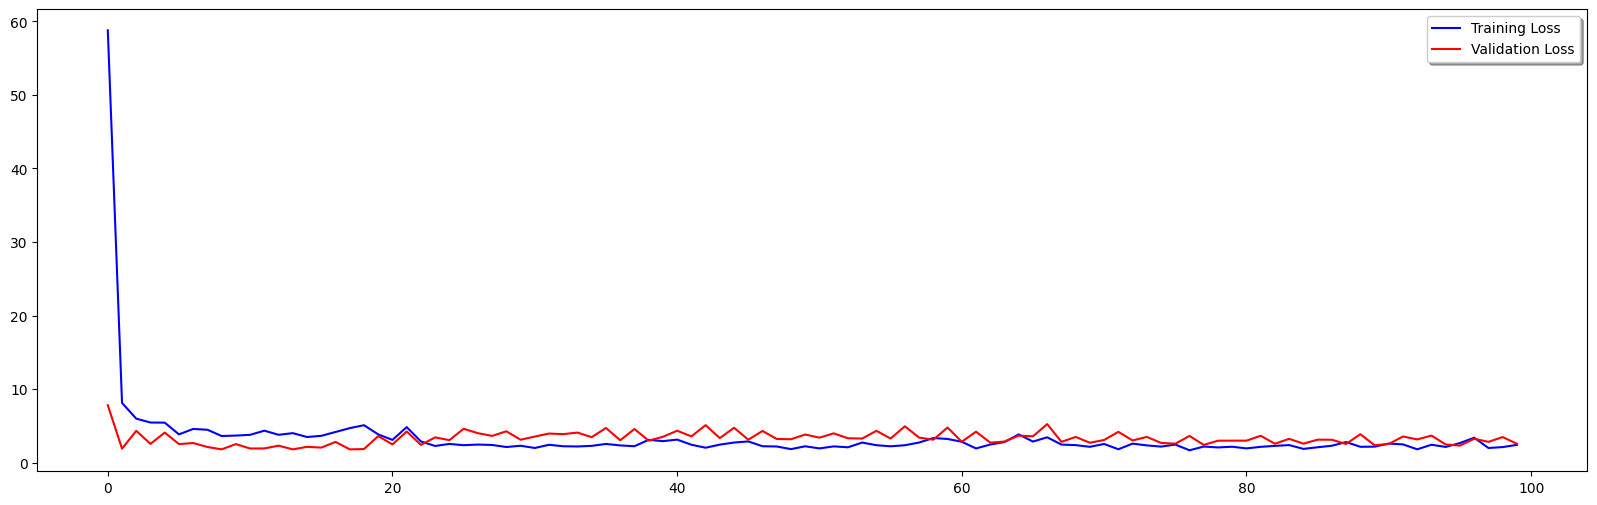

In [10]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(logs['train_loss'], color='b', label="Training Loss")
ax.plot(logs['valid_loss'], color='r', label="Validation Loss")
legend = ax.legend(loc='best', shadow=True)

In [11]:
torch.save(model, 'Transformer_model.pth')